In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from IPython.core.pylabtools import figsize
from __future__ import print_function

import os
import sys
import glob
import time
import numpy as np
import numpy.random as nr

from keras.preprocessing.image import load_img, img_to_array, array_to_img

from keras.models import Model
from keras.applications import vgg16

from scipy.misc import imsave
from scipy.optimize import fmin_l_bfgs_b

np.set_printoptions(precision=3, linewidth=120, suppress=True)

Using TensorFlow backend.


In [2]:
sys.path.append('../src')
from my_keras_utilities import get_available_gpus
import keras.backend as K
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


In [3]:
figdir = '../figures/style_transfer/'
resdir = figdir + 'results/'
os.makedirs(resdir, exist_ok=True)
image_file_path = figdir + 'museu_by_bruna.png'
style_file_path = figdir + 'tolouse-lautrec.png'

width, height = load_img(image_file_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

def deprocess_image(a):
    x = a.copy()
    x = x.reshape(img_nrows, img_ncols, 3)
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

print('Shape of the images: {} rows, {} columns'.format(img_nrows, img_ncols))

Shape of the images: 400 rows, 499 columns


(1, 400, 499, 3) -116.779 131.32


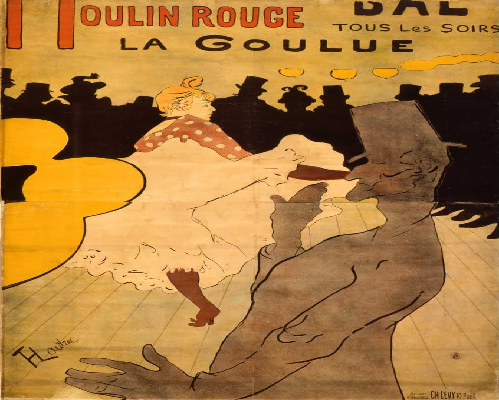

In [4]:
vgg_image = preprocess_image(image_file_path)
vgg_style = preprocess_image(style_file_path)

print(vgg_style.shape, vgg_style.min(), vgg_style.max())

array_to_img(deprocess_image(vgg_style[0]))

In [5]:
from keras.applications.vgg16 import VGG16
# from vgg16_avg import VGG16_Avg as VGG16

vgg = VGG16(include_top=False, weights='imagenet', input_shape=vgg_image.shape[1:])
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 499, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 499, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 499, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 249, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 249, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 249, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 124, 128)     0         
__________

In [6]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

def style_loss(output, target): 
    x_gram = gram_matrix(output)
    t_gram = gram_matrix(target)
    return K.mean(K.square(x_gram - t_gram))

class Evaluator(object):
    def __init__(self, fun, shp): 
        self.funct = fun
        self.shape = shp
        
    def get_loss(self, x):
        loss, self.grad_values = self.funct([x.reshape(self.shape)])
        return loss.astype(np.float64)

    def get_grads(self, x): 
        return self.grad_values.flatten().astype(np.float64)
    
def my_solver(obj, niter, x):
    images = []
    try:
        for i in range(niter):
            x, min_val, info = fmin_l_bfgs_b(obj.get_loss, x.flatten(), fprime=obj.get_grads, maxfun=20)
            x = np.clip(x, -127, 127)
            print('{:2d}. loss: {:.3f}'.format(i, min_val))    
            images.append(x.copy())
    except KeyboardInterrupt:
        print('Interrupted!!')
    finally:
        return images

In [7]:
vgg_output_dict = {layer.name: layer.output for layer in vgg.layers}
style_outputs = [vgg_output_dict['block{}_conv1'.format(o)] for o in range(1,3)]

style_model = Model(vgg.input, style_outputs)
style_targets = [K.variable(o) for o in style_model.predict(vgg_style)]

In [8]:
style_weights = [0.05, 0.05, 0.15, 0.25, 0.5]
loss = sum(w * style_loss(out[0], targ[0]) for out, targ, w in zip(style_outputs, style_targets, style_weights))

grads = K.gradients(loss, vgg.input)
style_fn = K.function([vgg.input], [loss]+grads)
evaluator = Evaluator(style_fn, vgg_style.shape)

In [9]:
x = np.random.uniform(-2.5, 2.5, vgg_image.shape)
# x = scipy.ndimage.filters.gaussian_filter(x, [0, 2, 2, 0])

In [10]:
A = my_solver(Evaluator(style_fn, vgg_image.shape), 10, x)

 0. loss: 493.395
 1. loss: 82.317
 2. loss: 33.900
 3. loss: 17.413
 4. loss: 11.442
 5. loss: 8.605
 6. loss: 6.872
 7. loss: 5.620
 8. loss: 4.791
 9. loss: 4.239


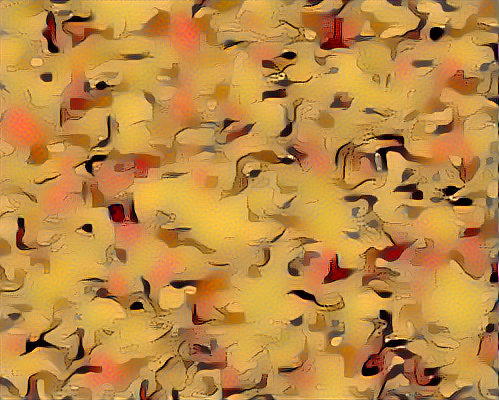

In [11]:
array_to_img(deprocess_image(A[-1]))